## Developer Programming Language Analysis by Use and Interest

### Section 1: Business Understanding
We are going to use the Stackoverflow annual developer survey to examine developer language preferences over the last five years for developers located in the United States.


1. How has use and interest in various programming languages changed from 2016 to 2020?
2. Which languages have the most hype (2020 results)?
3. How does language interest vary by each language in use and what insights can we gain (2020 results)?
4. Which languages are most likely to be used together (2020 results)?

### Section 2: Data Understanding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Libraries for Embedded Sparklines
import sparklines
import base64
import requests
from time import sleep
from itertools import chain
from io import BytesIO
from datetime import timedelta, date
from IPython.display import display, HTML


%matplotlib inline
%pylab inline

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_seq_items', 100)


def sparkline(data, figsize=(4, 0.25), **kwags):
    '''
    Returns a HTML image tag containing a base64 encoded sparkline style plot
    Enables embedded sparklines in pandas
    Ref - https://github.com/iiSeymour/sparkline-nb
    '''
    data = list(data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    ax.plot(data)
    for k,v in ax.spines.items():
        v.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])    

    plt.plot(len(data) - 1, data[len(data) - 1], 'r.')

    ax.fill_between(range(len(data)), data, len(data)*[min(data)], alpha=0.1)
    
    img = BytesIO()
    plt.savefig(img)
    img.seek(0)
    plt.close()
    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()).decode())

Populating the interactive namespace from numpy and matplotlib


In [2]:
schema_2017 = pd.read_csv('survey_results_schema_2017.csv')
schema_2018 = pd.read_csv('survey_results_schema_2018.csv')
schema_2019 = pd.read_csv('survey_results_schema_2019.csv')
schema_2020 = pd.read_csv('survey_results_schema_2020.csv')

In [3]:
for i in [schema_2017,schema_2018,schema_2019,schema_2020]:
    print(i.shape)


(154, 2)
(129, 2)
(85, 2)
(61, 2)


Exploring the schemas for each year we can see that they differ from one year to the next. Let's ensure we have the necessary data to answer our questions by examining the schema files. Note, in the case of 2016 schema information was provided in a ReadMe. It shows that the schema contains the following columns that are relevant to our analysis:

- 'tech_do' --- Which of the following languages or technologies have you done extensive development with in the last year? 
- 'tech_want' --- Which of the following languages or technologies do you WANT to work with this year?

In [4]:
dict = {}
x = 2017
for i in [schema_2017,schema_2018,schema_2019,schema_2020]:
    lang_questions = set(i[i['Column'].str.contains('Lang')]['Column'])
    lang_values = set
    dict[x] = lang_questions
    x+=1
    
pd.DataFrame(dict.items())
    

,0,1
0,2017,"{WantWorkLanguage, HaveWorkedLanguage}"
1,2018,"{LanguageWorkedWith, LanguageDesireNextYear}"
2,2019,"{LanguageWorkedWith, LanguageDesireNextYear}"
3,2020,"{LanguageWorkedWith, LanguageDesireNextYear}"


We can conclude that the data we are interested in pulling is available from each of the last 5 years. We'll concatenate each year's file into a single dataframe for further analysis.

In [5]:
usecols = ['LanguageDesireNextYear' ,'LanguageWorkedWith', 'Country']
df_2020 = pd.read_csv('survey_results_public_2020.csv', usecols = usecols)[usecols]
df_2020['Year'] = 2020

usecols = ['LanguageDesireNextYear' ,'LanguageWorkedWith', 'Country']
df_2019 = pd.read_csv('survey_results_public_2019.csv', usecols = usecols)[usecols]
df_2019['Year'] = 2019
df_2019.columns = df_2020.columns

usecols = ['LanguageDesireNextYear' ,'LanguageWorkedWith', 'Country']
df_2018 = pd.read_csv('survey_results_public_2018.csv', usecols = usecols)[usecols]
df_2018['Year'] = 2018
df_2018.columns = df_2020.columns

usecols = ['WantWorkLanguage' ,'HaveWorkedLanguage', 'Country']
df_2017 = pd.read_csv('survey_results_public_2017.csv', usecols = usecols)[usecols]
df_2017['Year'] = 2017
df_2017.columns = df_2020.columns

usecols = ['tech_want' ,'tech_do', 'country']
df_2016 = pd.read_csv('2016 Stack Overflow Survey Responses.csv', usecols = usecols)[usecols]
df_2016['Year'] = 2016
df_2016.columns = df_2020.columns

df_history = pd.concat([df_2020, df_2019, df_2018, df_2017, df_2016], axis=0)
df_history = df_history[df_history['Country'] == 'United States']
df_history = df_history.rename(columns={'LanguageDesireNextYear':'LanguageInterest', 'LanguageWorkedWith':'LanguageUsed'})
df_history.head()


C:\Users\peter\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (65,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LanguageInterest,LanguageUsed,Country,Year
4,Java;Ruby;Scala,HTML/CSS;Ruby;SQL,United States,2020
7,JavaScript,Python;SQL,United States,2020
13,HTML/CSS;JavaScript;SQL;TypeScript,HTML/CSS;JavaScript;SQL;TypeScript,United States,2020
16,C#;Go;Haskell;HTML/CSS;JavaScript;Python;Ruby;Rust;SQL,C#;HTML/CSS;JavaScript;Python;SQL;VBA,United States,2020
17,HTML/CSS;Perl,Bash/Shell/PowerShell;HTML/CSS;Perl,United States,2020


Let's take a closer look at df_history.

<AxesSubplot:>

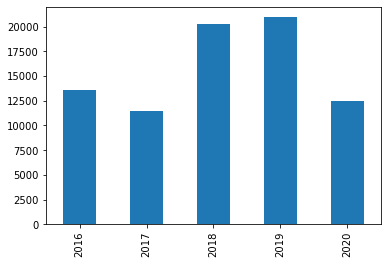

In [6]:
df_history['Year'].value_counts().sort_index().plot(kind='bar')

In [7]:
# Data coverage percentage (Not Null) by year
df_history.groupby('Year').count().div(df_history.groupby('Year').size(), axis=0)


,LanguageInterest,LanguageUsed,Country
Year,,,
2016,0.882192,0.907896,1.0
2017,0.721170,0.777477,1.0
2018,0.809001,0.871239,1.0
2019,0.945964,0.991408,1.0
2020,0.873446,0.932954,1.0


### Section 3: Data Preparation

Since the language used and language desired questions allow for multiple answers on the survey, we will setup a function to explode the nested data into separate rows.

In [8]:
def splitAndExplode(df, col, delimiter=','):
    '''
    DESCRIPTION - explodes nested info from specified column containing nested data. Creates new rows with new index.
        Null instances of nested column are thrown out. Also, white space is removed from extracted strings.
    INPUT:
      - df - dataframe
      - col - column name that contains nested info
        Returns new dataframe
    OUTPUT:
      - new dataframe with nested data exploded to new rows. 
    '''

    df = df[df[col].notnull()].copy()
    df[col] = df[col].str.split(delimiter)
    df = df.explode(col, ignore_index=True)
    df[col] = df[col].str.replace(' ','')
    return df

In [9]:
df_lang = df_history.drop(['Country'], axis=1)
df_lang = splitAndExplode(df_lang, 'LanguageInterest', ';')
df_lang = splitAndExplode(df_lang, 'LanguageUsed', ';')

df_lang.shape

(1955391, 3)

In [10]:
pd.pivot_table(df_lang[['LanguageInterest','Year']]
               , index=['LanguageInterest'], columns=['Year']
               , aggfunc=len, fill_value=0).head()

Year,2016,2017,2018,2019,2020
LanguageInterest,,,,,
Android,15221,0,0,0,0
AngularJS,14362,0,0,0,0
Arduino/RaspberryPi,10239,0,0,0,0
Assembly,0,2616,8654,7816,3747
Bash/Shell,0,0,42531,0,0


The sample of the summary above shows that there are a couple issues. Due to the phrasing of the survey question, year 2016 responses include platforms and technologies in addition to languages. Also, a few of the years include similar one-offs. To help standardize the responses between years and in effect drop non-language data, we will drop any language values where the language only occurred in one year and then normalize the results for each year to account for the varying number of respondents in each survey.

In [11]:
lang_year_occurance = df_lang.groupby(['LanguageInterest'])['Year'].nunique()
lang_filter = lang_year_occurance[lang_year_occurance>2].index.tolist()

df_lang = df_lang[df_lang['LanguageInterest'].isin(lang_filter) & df_lang['LanguageUsed'].isin(lang_filter)]
df_lang.head()

,LanguageInterest,LanguageUsed,Year
1,Java,Ruby,2020
2,Java,SQL,2020
4,Ruby,Ruby,2020
5,Ruby,SQL,2020
7,Scala,Ruby,2020


### Section 4: Evaluation

#### 1. How has use and interest in various programming languages changed since 2016?

Let's crosstab the responses and then transpose for easier viewing. We will also summarize the 4 year trend for each language with sparklines and add ranking.

In [12]:
df = pd.crosstab(index=df_lang['Year'], columns=df_lang['LanguageUsed'], normalize='index')

df.columns.name = None
df.index.name = 'LanguageUsed'
df = df.T

df['2016-2020'] = df.values.tolist()
df['2016-2020'] = df['2016-2020'].map(sparkline)
df['PercentUse_2016'] = df[2016]
df['PercentUse_2020'] = df[2020]
df['4yrDiff'] = df[2020] - df[2016]
df['Rank2016'] = df[2016].rank(ascending=False, method='dense').astype('int')
df['Rank2020'] = df[2020].rank(ascending=False, method='dense').astype('int')
df['RankChange'] = (df['Rank2016'] - df['Rank2020']).astype('int')
df = df.iloc[:,5:]
df_ct_used = df.sort_values(by=['Rank2020'])

HTML(df_ct_used.style.format({'PercentUse_2016': '{:,.2%}'.format,
                                       'PercentUse_2020': '{:,.2%}'.format,
                                       '4yrDiff' : '{:,.2%}'.format})\
                 .background_gradient(cmap='RdBu', subset=['4yrDiff', 'RankChange']).render())

LanguageUsed,2016-2020,PercentUse_2016,PercentUse_2020,4yrDiff,Rank2016,Rank2020,RankChange
JavaScript,,17.51%,16.05%,-1.46%,1,1,0
SQL,,14.72%,13.64%,-1.09%,2,2,0
Python,,10.12%,12.14%,2.02%,5,3,2
Java,,11.36%,8.61%,-2.75%,3,4,-1
C#,,10.17%,7.81%,-2.36%,4,5,-1
TypeScript,,0.00%,6.45%,6.45%,22,6,16
C++,,6.73%,5.44%,-1.29%,6,7,-1
C,,5.41%,4.74%,-0.67%,8,8,0
PHP,,6.39%,4.21%,-2.18%,7,9,-2
Go,,1.35%,2.96%,1.62%,14,10,4


In [13]:
df = pd.crosstab(index=df_lang['Year'], columns=df_lang['LanguageInterest'], normalize='index')

df.columns.name = None
df.index.name = 'LanguageInterest'
df = df.T

df['2016-2020'] = df.values.tolist()
df['2016-2020'] = df['2016-2020'].map(sparkline)
df['PercentInterest_2016'] = df[2016]
df['PercentInterest_2020'] = df[2020]
df['4yrDiff'] = df[2020] - df[2016]
df['Rank2016'] = df[2016].rank(ascending=False, method='dense').astype('int')
df['Rank2020'] = df[2020].rank(ascending=False, method='dense').astype('int')
df['RankChange'] = (df['Rank2016'] - df['Rank2020']).astype('int')
df = df.iloc[:,5:]
df_ct_interest = df.sort_values(by=['Rank2020'])

HTML(df_ct_interest.style.format({'PercentInterest_2016': '{:,.2%}'.format,
                                       'PercentInterest_2020': '{:,.2%}'.format,
                                       '4yrDiff' : '{:,.2%}'.format})\
                 .background_gradient(cmap='RdBu', subset=['4yrDiff', 'RankChange']).render())

LanguageInterest,2016-2020,PercentInterest_2016,PercentInterest_2020,4yrDiff,Rank2016,Rank2020,RankChange
Python,,10.53%,12.04%,1.51%,2,1,1
JavaScript,,12.52%,11.29%,-1.22%,1,2,-1
SQL,,8.13%,9.93%,1.79%,4,3,1
TypeScript,,0.00%,8.28%,8.28%,22,4,18
Rust,,3.02%,7.11%,4.09%,13,5,8
C#,,8.72%,7.04%,-1.69%,3,6,-3
Go,,5.01%,6.72%,1.71%,8,7,1
Java,,7.53%,4.99%,-2.54%,5,8,-3
C++,,6.74%,4.91%,-1.83%,6,9,-3
Kotlin,,0.00%,3.87%,3.87%,22,10,12


#### 2. Which languages have the most hype (2020 results)?

We'll measure "hype" by dividing interest by use for each language. Larger values represent langauges that have more interest than use and therefore we will classify any language with a value greater than 1 as being hyped.

Since Clojure, CoffeeScript, Erlang, and #F have effectively dropped to 0.00 in use and interest they will be removed from analysis.

In [14]:
df = pd.concat([df_ct_interest['PercentInterest_2020'], df_ct_used['PercentUse_2020']], axis=1)
df = df[~df.index.isin(['Clojure', 'CoffeeScript', 'Erlang', 'F#'])]
df['Hype'] = df['PercentInterest_2020'] / df['PercentUse_2020']
df.sort_values('Hype', ascending=False)

,PercentInterest_2020,PercentUse_2020,Hype
Rust,0.071104,0.018291,3.887402
Julia,0.010833,0.003405,3.181138
Haskell,0.019988,0.006887,2.902295
Kotlin,0.038723,0.015599,2.482353
Go,0.067240,0.029634,2.269052
Dart,0.014819,0.007371,2.010373
Swift,0.033090,0.018423,1.796071
Scala,0.018643,0.010879,1.713683
TypeScript,0.082768,0.064472,1.283783
R,0.022573,0.017745,1.272048


Since it's much easier to have a higher hype value if the language used is relatively small, we'll plot the normalized use vs interest using a bubble chart in order to have a better perspective where we can clearly understand the hype measure within the context of it's denominator (language use).

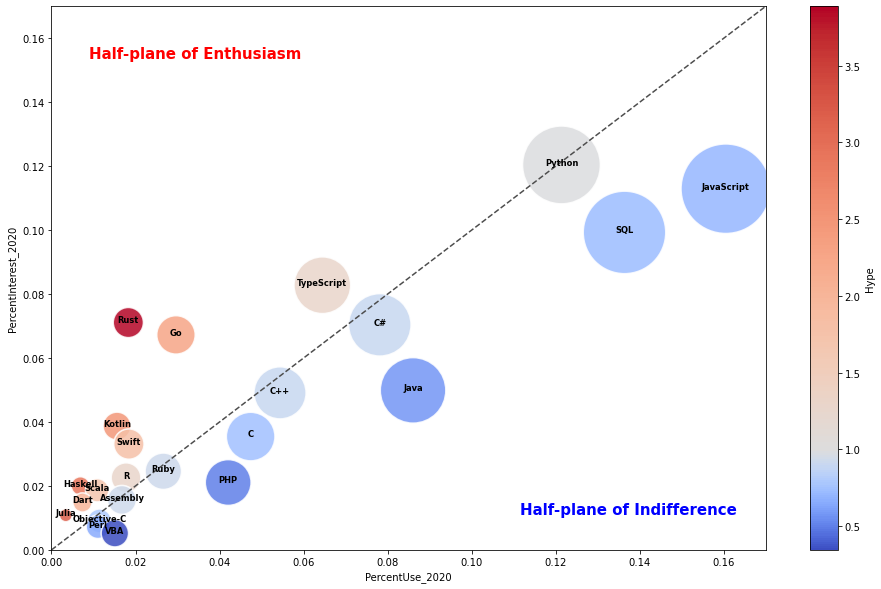

In [15]:
from matplotlib import colors


plt.figure(figsize = (16,10))

x = df.PercentUse_2020
y = df.PercentInterest_2020
bubble_size = df.PercentUse_2020 * 50000
colors = df.Hype

cmap = 'coolwarm'
vmin = df.Hype.min()
vmax = df.Hype.max()
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)    


ax = sns.scatterplot(x=x, y=y, alpha = 0.85, c= colors, s = bubble_size, cmap=cmap, norm=norm)
ax.set_xlim(0,.17)
ax.set_ylim(0,.17)

ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.text(0.35, .9, 'Half-plane of Enthusiasm',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='Red', fontsize=15, weight='semibold')

ax.text(0.96, 0.06, 'Half-plane of Indifference',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='blue', fontsize=15, weight='semibold')


#Add label for each bubble
for line in range(0,df.shape[0]):
     ax.text(df.PercentUse_2020[line], df.PercentInterest_2020[line], df.index[line], 
             horizontalalignment='center', size='small', color='black', weight='semibold')
    
ax.figure.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm)).set_label('Hype')


Upper left hand side of plot shows languages that are ranked higher in use than interest and vice-versa. Size of bubble indicates relative size of language by use. Color of bubble corresponds to hype value. This plot uses a diverging color palette with midpoint at a hype value of 1 (where use and interest are equivalant).

#### 3. How does language interest vary by each language in use and what insights can we gain (2020 results)?


Now we'll take a look at the relationship between used languages and languages of interest.

<AxesSubplot:xlabel='LanguageInterest', ylabel='LanguageUsed'>

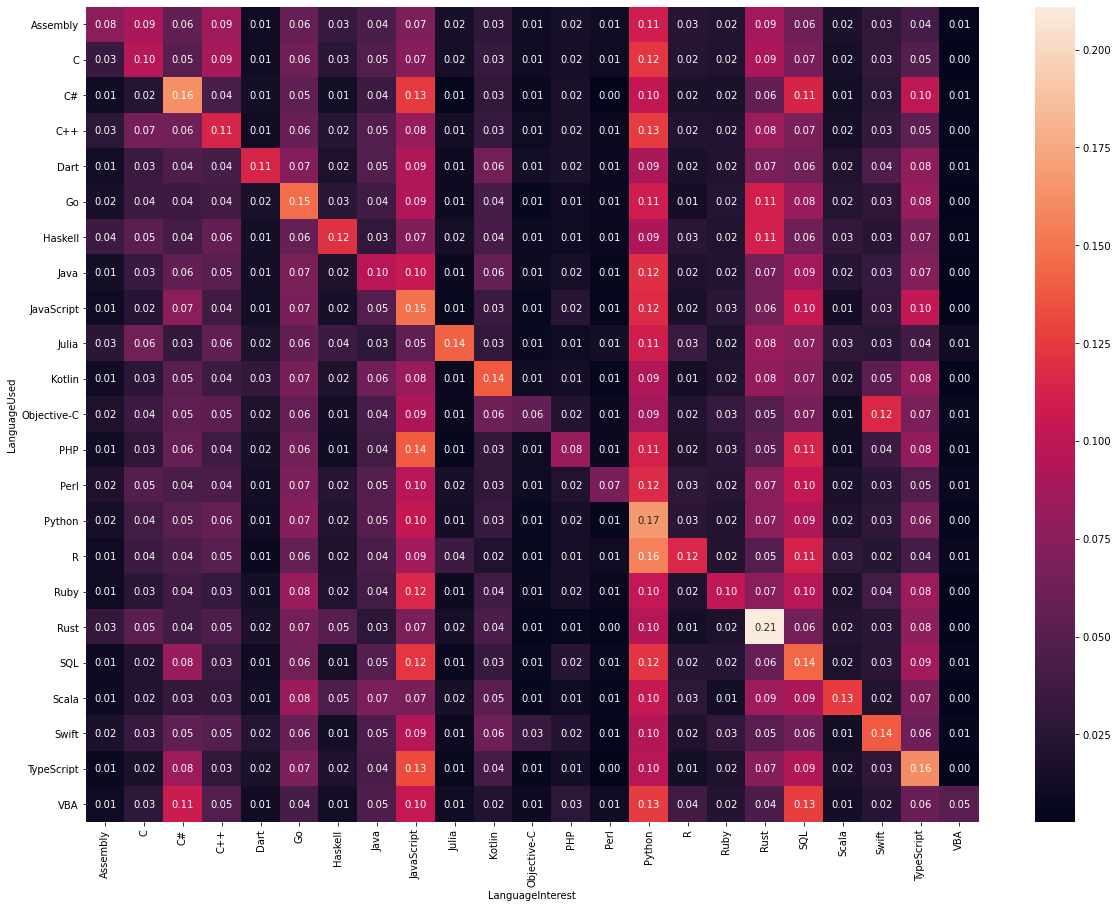

In [16]:
df_lang2020 = df_lang[df_lang['Year'] == 2020]
df = pd.crosstab(index=df_lang2020['LanguageUsed'], columns=df_lang2020['LanguageInterest'], normalize='index')

plt.figure(figsize=(20,15))
sns.heatmap(df,annot=True, fmt='.2f')

Since this crosstab is normalized all column and rows will add up to 23 each (23 languages). Additionally each individual row adds up to 1 since we are looking at interest allocation by each lanugage used (each individual language used has 100% to allocate among interests). This means aside from looking at the heatmap we can get a sense for which langauges are universally liked by taking the mean or median of the columns.

In [17]:
df.median(axis=0).sort_values(ascending=False)

LanguageInterest
Python         0.109281
JavaScript     0.092669
SQL            0.087490
Rust           0.074301
TypeScript     0.067351
Go             0.063758
C#             0.051296
C++            0.045708
Java           0.045286
C              0.034578
Kotlin         0.034430
Swift          0.028901
Ruby           0.021965
R              0.021741
Haskell        0.019926
Scala          0.018203
PHP            0.015815
Assembly       0.013920
Dart           0.013788
Julia          0.009682
Objective-C    0.009122
Perl           0.007741
VBA            0.005181
dtype: float64

#### 4. Which languages are most likely to be used together (2020 results)?

Given that the survey results allowed each respondent to provide multiple answers, we can take the original dataset (prior to exploding each answer into it's own row) and treat each response to the language used question as a basket of goods. This looks like a good candidate for association rules mining.

In [18]:
df_history_2020 = df_history[df_history['Year'] == 2020]
lang_used_basket = df_history[df_history['LanguageUsed'].notnull()]['LanguageUsed'].copy()
lang_used_basket = lang_used_basket.str.replace(' ','').str.split(';').tolist()

te = TransactionEncoder()
te_array = te.fit(lang_used_basket).transform(lang_used_basket)
df_basket = pd.DataFrame(te_array, columns=te.columns_)[lang_filter]
df_basket.head()

,Assembly,C,C#,C++,Clojure,CoffeeScript,Dart,Erlang,F#,Go,...,Perl,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
3,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


##### Applying Apriori

In [19]:
df_freq_itemset = apriori(df_basket, min_support=0.2,use_colnames=True)
df_freq_itemset


,support,itemsets
0,0.340449,(C#)
1,0.215979,(C++)
2,0.369709,(Java)
3,0.683620,(JavaScript)
4,0.439742,(Python)
5,0.551575,(SQL)
6,0.257567,"(JavaScript, C#)"
7,0.235826,"(SQL, C#)"
8,0.261410,"(JavaScript, Java)"
9,0.214240,"(SQL, Java)"


##### Mining Association Rules

In [20]:
df_rules = association_rules(df_freq_itemset, metric='confidence', min_threshold=.6)
df_rules.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(SQL),(JavaScript),0.551575,0.683620,0.431972,0.783160,1.145608,0.054904,1.459051
0,(C#),(JavaScript),0.340449,0.683620,0.257567,0.756551,1.106683,0.024829,1.299573
2,(Java),(JavaScript),0.369709,0.683620,0.261410,0.707072,1.034305,0.008670,1.080060
1,(C#),(SQL),0.340449,0.551575,0.235826,0.692691,1.255842,0.048043,1.459199
3,(Python),(JavaScript),0.439742,0.683620,0.288524,0.656119,0.959772,-0.012093,0.920029
4,(JavaScript),(SQL),0.683620,0.551575,0.431972,0.631889,1.145608,0.054904,1.218178


Of the results, the most interesting rules based on conviction are:
- C# → SQL
- SQL →Javascript.